### Automatic Ticket Classification 
##### Khan Imran Jabbar 

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json',)
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
# Checking Shape
df.shape

(78313, 22)

In [6]:
# Getting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#Printing the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assigning new column names - Removing _ before the column names
pattern ="^_"
df.columns=[re.sub(pattern,'',name) for name in df.columns]

In [9]:
# Checking to see if the columns were renamed as expected
df.columns

Index(['index', 'type', 'id', 'score', 'source.tags', 'source.zip_code',
       'source.complaint_id', 'source.issue', 'source.date_received',
       'source.state', 'source.consumer_disputed', 'source.product',
       'source.company_response', 'source.company', 'source.submitted_via',
       'source.date_sent_to_company', 'source.company_public_response',
       'source.sub_product', 'source.timely', 'source.complaint_what_happened',
       'source.sub_issue', 'source.consumer_consent_provided'],
      dtype='object')

In [10]:
# Removing source from the column names wherever it starts with source
pattern ="source."
df.columns=[re.sub(pattern,'',name) for name in df.columns]

In [11]:
# Checking to see if the columns were renamed as expected
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [12]:
# Creating a new df checkblank to hold data where the complaints are blank,
# This is just a step to visually check the data, and also assigning to a temp df ensures we don't change anything on runtime
checkblank=df.loc[(df['complaint_what_happened'] == "") ]

In [13]:
# Checking to see how many blanks we have and also what the DF looks like
print(checkblank.shape)
checkblank.head(10)

(57241, 22)


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A
12,complaint-public-v2,complaint,3362102,0.0,None,08701,3362102,Closing an account,2019-09-04T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-09-04T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,Consent not provided
13,complaint-public-v2,complaint,3319930,0.0,None,420XX,3319930,Incorrect information on your report,2019-07-26T12:00:00-05:00,KY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-07-26T12:00:00-05:00,None,Credit reporting,Yes,,Information belongs to someone else,Consent not provided


In [ ]:
# Reverting processing back to the original df

In [14]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"].replace("",np.nan, inplace=True)

In [15]:
# Checking the number of nan's per column
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [16]:
#Remove all rows where complaints column is nan
# nan's were orignally blank complaints and because they are not going to provide any information for our work, 
# they will be dropped
df.dropna(subset="complaint_what_happened", inplace=True)

In [17]:
# Checking to see if we eliminated nan's from complaint_what_happened column
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

In [ ]:
## We have successfuly removed the rows where the complaints were blank

In [18]:
# Checking the df again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Preparing the text for topic modeling

Steps Done
* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove masks (eg-xx)
* Remove words containing numbers


After the text cleaning these steps were performed
* Lemmatize the texts - Please also check notes before the lemmatize function
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


##### Before the text clean up process we went through the text and visually/manually inspected the text to see what we were removing and what information we would lose by doing so. This was done mostly to check for information lose for text within the [ ]


In [19]:
# Data in complains columns seems to have [] with text in between, we will remove it. we will do an inspection to 
# check what the data in [] is . To do that, we will assign a new dataframe called sqaure with complains that have []
# in them

# This function uses the same logic that we used above to first assign nans to blank complaints and than dropping them

def checksquare(x):
    pattern="\[.*?\]"
    check = re.search(pattern,x)
    if check:
        return x
    else:
        return np.nan

In [20]:
# Checking the data before we started removing the data in []
square=df["complaint_what_happened"].apply(lambda x: checksquare(x))

In [21]:
# Keeping only rows where the complaints have square brackets in them
square.dropna(how="all", inplace=True)

In [22]:
#checking the square df
square

316      RE : Complaint Against JP Morgan Chase, XXXX Home Lending Advisor, Ms. XXXX XXXX and Manager, Mr. XXXX XXXX SUBJECT : Refinancing Home Loan via Chase Home Loan No.  XXXX Mr. XXXX XXXX, with regards to your deference to Chase Executive office based upon your interpretation of my e-mail dated XXXX XXXX, XXXX, that the correspondence intimated a threat of suit, perhaps the terseness of the narrative may have animated such an inference, but it was merely a correspondence of frustration invoked by my interpretation of an apparent deficiency of candor in what would appear to be a simple and mechanical process based on basic Standards of Care. \n\nFrom XX/XX/XXXX until Friday, XX/XX/XXXX Ms. XXXX, XXXX Home Loan Advisor, Agent of JP Morgan Chase unacceptable conduct along with email communication that is part of the record clearly supports the allegations of Unfair Business Practices and Fraudulent Business Practices. \n\nCOMMON SENSE : The Standards of Care which affords common sens

In [23]:
# checking a few individual complain ( indexes are listed above so we are using random ones from there)
square[316]

'RE : Complaint Against JP Morgan Chase, XXXX Home Lending Advisor, Ms. XXXX XXXX and Manager, Mr. XXXX XXXX SUBJECT : Refinancing Home Loan via Chase Home Loan No.  XXXX Mr. XXXX XXXX, with regards to your deference to Chase Executive office based upon your interpretation of my e-mail dated XXXX XXXX, XXXX, that the correspondence intimated a threat of suit, perhaps the terseness of the narrative may have animated such an inference, but it was merely a correspondence of frustration invoked by my interpretation of an apparent deficiency of candor in what would appear to be a simple and mechanical process based on basic Standards of Care. \n\nFrom XX/XX/XXXX until Friday, XX/XX/XXXX Ms. XXXX, XXXX Home Loan Advisor, Agent of JP Morgan Chase unacceptable conduct along with email communication that is part of the record clearly supports the allegations of Unfair Business Practices and Fraudulent Business Practices. \n\nCOMMON SENSE : The Standards of Care which affords common sense to pre

In [24]:
# checking a few individual complain ( indexes are listed above so we are using random ones from there)
square[76906]

'Dear Sir, I have closed my individual chase credit card on XXXX XXXX by paying off complete balance amount to XXXX. My closed Individual credit card information is missing in the XXXX  credit report since XX/XX/2018. I have communicated to XXXX  about this card, right name and address along with various details. I have also communicated to Chase Credit Card Company to update the right status of closed credit card to all credit bureaus and also Information/Grievance is part of the CFPB records. Chase has responded to me and CFPB that CHASE credit has been paid and closed with XXXX balance on XXXX XXXX and also Chase has communicated to all the credit bureau that my credit card is closed on XXXX XXXX but this information is missing in the XXXX   Credit Report. I have only used chase credit card for my purchases [ all my transactions are part of the statements ] and used as normal credit card and I never ever used any kind of benefits from chase. \nCould CFPB kindly direct XXXX/Chase to 

In [25]:
#Looking at the data above, we have a fair idea of what the [] contains
## It doesn't look like we will lose a lot of important information by dropping the text within the square brackets

In [26]:
                                    ##### NOTE####
# On inspection we see that the texts contains xxxx , xx/xx/xxxx and xx/xx/ which most probably ia a masks for some information.
# We will also try and clean this too




### Function to clean the text
* Step 1 - Build the function
* Step 2 - Test the function

In [254]:
# Building the function
# Tasks perfomed in this function
# - change case to lower
# - remove [] and text within
# - Remove XX and related masks
# - Remove punctuation
# - Remove words containing numbers

def getnewtext(text):
    # Convert to lower case
    text=text.lower()
    
    # Remove Square Bracket and text within
    pattern="\[.*?\]"
    text= re.sub(pattern,"",text)
    
    #Remove all XX patterns - Note : Where the text is xx/xx/xxxx or xx/xx/number, replacing xx will leave behind "/"
    # but this "/" will be removed when we remove punctutaions
    
    pattern ="x{2,}" # --- lower X becaused the whole text is already lowered. We are using xx as a pattern because there is a 
                  # high probalility that there are no words containing "xx" - 
                  # https://www.worddb.com/words/containing/xx
            
    text= re.sub(pattern,"",text)
    
    # Remove Punctuations - Here we will use translate method from string library 
    text =text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers(? including numbers)
    pattern ="\w*\d\w*"
    text= re.sub(pattern,"",text)
    
    #correcting whitespace issues if any
    
    text = " ".join(text.split())
    return text

In [28]:
## Test the getnewtext function===> Test 1 

# Lets test the getnewtext function with a random string and see if we are able to return the correct output
teststring ="This is a [test], we are ch3cking if the function work 1234 ABC123   123abc it's  "
getnewtext(teststring)

'this is a we are if the function work its'

In [29]:
#Test 1 Passed

In [30]:
## Test the getnewtext function===> Test 2
# Lets also test the function with one of the entry from the temp dataframe square that we had build
print(square[76906])
print("*"*100)
print(getnewtext(square[76906]))

Dear Sir, I have closed my individual chase credit card on XXXX XXXX by paying off complete balance amount to XXXX. My closed Individual credit card information is missing in the XXXX  credit report since XX/XX/2018. I have communicated to XXXX  about this card, right name and address along with various details. I have also communicated to Chase Credit Card Company to update the right status of closed credit card to all credit bureaus and also Information/Grievance is part of the CFPB records. Chase has responded to me and CFPB that CHASE credit has been paid and closed with XXXX balance on XXXX XXXX and also Chase has communicated to all the credit bureau that my credit card is closed on XXXX XXXX but this information is missing in the XXXX   Credit Report. I have only used chase credit card for my purchases [ all my transactions are part of the statements ] and used as normal credit card and I never ever used any kind of benefits from chase. 
Could CFPB kindly direct XXXX/Chase to up

In [31]:
#Test 2 Passed 

### Function to Lemmatize the text
* Step 1 - Build the function
* Step 2 - Test the function

## PLEASE NOTE


During the test runs, it was noticed that there was a high occurence of the word "wa" after lemmatizaton. This looked like it was a lemmatized version of "was". Further research confirmed that this is a known issue with WordNetLemmatizer.
The discussion on the topic can be found here

https://groups.google.com/g/nltk-users/c/b13B40AOyPE?pli=1

We than modified the code for the lemmatizer function to skip this error of lemmatization, because once its lemmatized as wa, the POS tag changes to NN, where as the pos tag for "was" should be verb. We confirmed this tagging by manually tagging a few sentences from the corpus here : https://parts-of-speech.info/

* Also note, we are not using the lemmatized text but complaint_what_happened after clean up for modelling, so it would not have a made a difference to the model if was/wa was present. This step was for EDA where "wa" ended up being one of the top 40 words and also became a big part of ngrams

In [32]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()
def lemmmatize(text):
    tokens = word_tokenize(text)
    ##### Important ### See Explanation above
    lemmatized = [wordnet_lemmatizer.lemmatize(token) if token!="was" else token for token in tokens]
    lemmatized =" ".join(word for word in lemmatized)
    return lemmatized


In [33]:
## Test the lemmmatize function===> Test 1

# Test the lemmmatize function using the a sample random statement for which we know what the lemmatized form should
# look like
lemmmatize("abaci dogs aardwolves fishes was")

'abacus dog aardwolf fish was'

In [34]:
# lemmatize function Test 1 passed

In [35]:
# Now that we know both of the functions work, lets apply them on our main dataframe df
# First we will apply the getnewtext function to clean the text as specified
# Applying getnewtext function on the complaint_what_happened column

df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x:getnewtext(x))

In [36]:
# Creating a new column called lemmatized complaints that we can obtain by passing the cleaned text to lemmatize function
df['lemmatized complaints'] = df['complaint_what_happened'].apply(lambda x:lemmmatize(x))

In [37]:
# Check the columns to see if we got the desired results
df[['complaint_what_happened','lemmatized complaints']]

,complaint_what_happened,lemmatized complaints
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only get ap

### df_clean

In [38]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df[['complaint_what_happened','lemmatized complaints']].copy(deep=True) 

# Lets also reset the index
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()

,complaint_what_happened,lemmatized complaints
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only get appl

In [39]:
# lets check the top 3 entries in df_clean 
df_clean.head(3)

,complaint_what_happened,lemmatized complaints
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant


In [40]:
# lets check the last 2 entries in df_clean 

df_clean.tail(2)

,complaint_what_happened,lemmatized complaints
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically since with no problems ever ive done many balance transfers in my life so i have plenty of experience i recently did a balance transfer with chase freedom for did many with other chase cards but apparently not freeedom when i got my first bill my minimum payment was i was shocked i immediately called on the representative told me that the min payment was so high bc they were making me pay the balance transfer fee up front but my future payments would be around of total balance which is standard and the rate they advertise i went to pay the next payment on was once again shocked to see my minimum payment was i paid it but i have been trying to work this out with chase ever since apparently the representative was wrong i am actually expected to pay instead of the standard they normally charge bc that was written in my user agreement paperwork back in years ago they currently charge to everyone else in the world my other cards including chase are all this is an unreasonable amt to expect someone to pay for credit card i have kids many other bills to pay they never warned me they were so off the charts with their minimum payment percentage except for my original paperwork in they offer everyone else terms they change their terms anytime it benefits them but wont budge to lower it to make this payment more affordable reasonable so i also asked them as soon as i found this out to refund my transfer fee so i could use it to transfer the balance to a different card with a more reasonable minimum payment they refused i also asked if they would transfer to my chase slate card which has min pmt they also refused they will not work with me at all i am a responsible working person i would like to preserve my good credit i could easily transfer again to a different card but id have to pay another lump sum of again,i have had flawless credit for yr ive had chase credit card chase freedom specifically since with no problem ever ive done many balance transfer in my life so i have plenty of experience i recently did a balance transfer with chase freedom for did many with other chase card but apparently not freeedom when i got my first bill my minimum payment was i was shocked i immediately called on the representative told me that the min payment was so high bc they were making me pay the balance transfer fee up front but my future payment would be around of total balance which is standard and the rate they advertise i went to pay the next payment on was once again shocked to see my minimum payment was i paid it but i have been trying to work this out with chase ever since apparently the representative was wrong i am actually expected to pay instead of the standard they normally charge bc that was written in my user agreement paperwork back in year ago they currently charge to everyone else in the world my other card including chase are all this is an unreasonable amt to expect someone to pay for credit card i have kid many other bill to pay they never warned me they were so off the chart with their minimum payment percentage except for my original paperwork in they offer everyone else term they change their term anytime it benefit them but wont budge to lower it to make this payment more affordable reasonable so i also asked them a soon a i found this out to refund my transfer fee so i could use it to transfer the balance to a different card with a more reasonable minimum payment they refused i also asked if they would transfer to my chase slate card which ha min pmt they also refused they will not work with me at all i am a responsible working person i would like to preserve my good credit i could easily transfer again to a different card but id have to pay another lump sum of again
21071,roughly years ago i closed out my accounts with jp morgan chase bank in order to close out an unsecured line of cred

#### POS TAG

In [41]:
#Write your function to extract the POS tags 

def pos_tag(sentences):
        newtext=[]
        sentences = [nltk.word_tokenize(sentences)]
        sentences = [nltk.pos_tag(sent) for sent in sentences]
        for words in sentences[0]:
            if(words[1]=="NN"):
                newtext.append(words[0])
        sentences=" ".join(word for word in newtext)
        return sentences

# Calling the pos_tag function on the complaint_POS_removed column and storing the result in lemmatized complaints column
df_clean["complaint_POS_removed"] =  df_clean['lemmatized complaints'].apply(lambda x:pos_tag(x))


In [42]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me,i card agent upgrade date agent information order account date consent recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immed

## EDA

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [43]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Lets assign the lengths of every complaint to a list called length
length= [len(text) for text in df_clean['complaint_POS_removed'] ]
# Lets see how many data points are in length
len(length)

21072

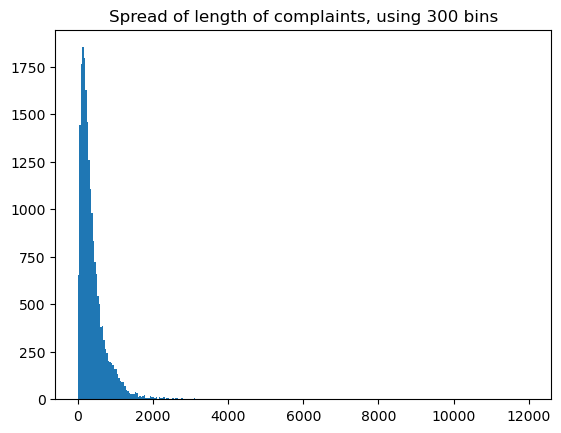

In [44]:
# Lets visualize the spread

plt.hist(length, bins=300)
plt.title("Spread of length of complaints, using 300 bins")
plt.show()

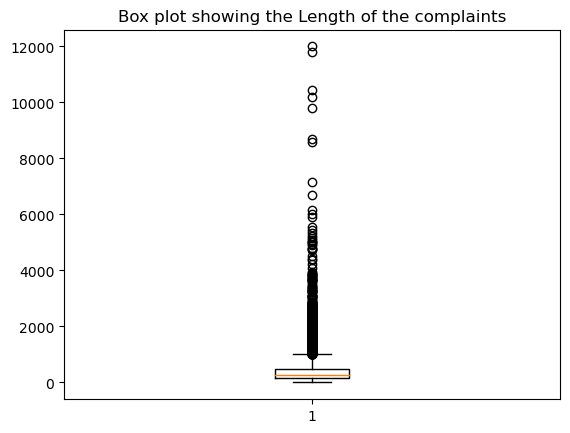

In [45]:
# Lets see the spread a little differenly using box plot
plt.boxplot(length)
plt.title("Box plot showing the Length of the complaints")
plt.show()

In [46]:
# Lets also see the chararteristic of the length of the complaints
pd.Series(length).describe()

count    21072.000000
mean       396.053863
std        448.047112
min          0.000000
25%        149.000000
50%        278.000000
75%        498.000000
max      11997.000000
dtype: float64

In [47]:
## Looks like we have complaints which have a len of zero (Post pos_tagging). Lets check how many of those we have
length.count(0)

8

In [48]:
#There are 8 rows with len zero in pos tagged columns. Given that there are only 8 and it is a fraction of the corpus,
# we will remove these ## -- Also note: There was no absolute certain reasoning for this. Our code would have worked 
# even if these remained. But assuming that post pos tagging, these rows offer no change to the overall data, we are removing it

# Shape of df_clean before dropping rows
df_clean.shape

(21072, 3)

In [49]:
# Dropping rows where len of complaint_POS_removed is zero
# Again: There is no explicit reason for dropping, we could have kept the data as our final modelling is not on this column
# This was more of a personal judgement call

df_clean = df_clean[df_clean['complaint_POS_removed'].str.len() != 0]


In [50]:
# Post dropping 
df_clean.shape

(21064, 3)

In [51]:
# Reassigning the length 
length = [len(text) for text in df_clean['complaint_POS_removed']]
# Checking the data points in the list
len(length)

21064

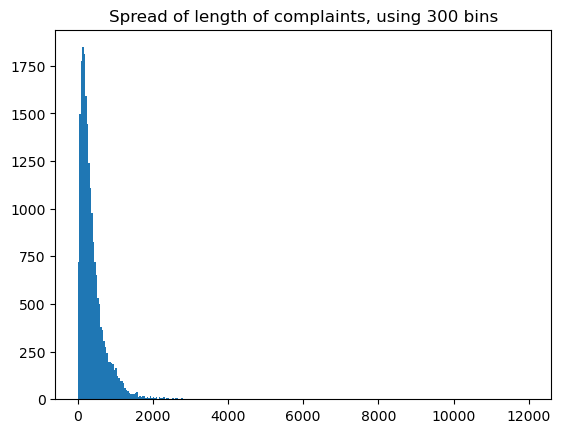

In [52]:
# Lets re-visualize the spread

plt.hist(length, bins=300)
plt.title("Spread of length of complaints, using 300 bins")
plt.show()

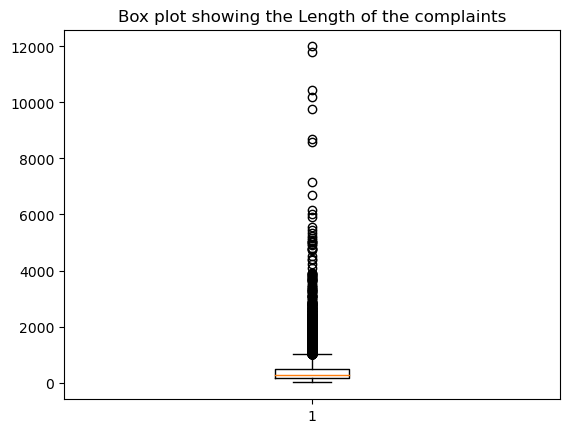

In [53]:
# Lets re-visualize the spread a little differenly using box plot
plt.boxplot(length)
plt.title("Box plot showing the Length of the complaints")
plt.show()

In [54]:
# Lets again see the chararteristic of the length of the complaints
pd.Series(length).describe()

count    21064.000000
mean       396.204282
std        448.065688
min          3.000000
25%        149.000000
50%        278.000000
75%        498.000000
max      11997.000000
dtype: float64

In [55]:
## Given that only 8 rows were dropped from a corpus of 21K+, we didn't really expect to see a change in the graphs

### Wordcloud
* Finding the top 40 words in the corpus 

In [57]:
# Install Wordcloud if not already installed
#pip install wordcloud

In [58]:
import wordcloud
from wordcloud import STOPWORDS, WordCloud
stop =set(STOPWORDS)

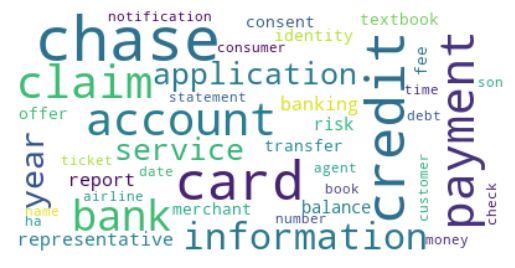

In [59]:
text=str(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(stopwords=stop,max_font_size=50, max_words=40, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
                    ############################NOTE############################
##### Remove - PRON-- 
## Old Artifact where PRON was added in the previous code, the code below will still run even if there was no -PRON- added

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [61]:
# N-grams
# We will make a new dataframe called df_ngram that will copy the Complaint_clean column to it and
# we will process this dataframe to get unigrams, bigrams and trigrams. This will ensure that our main data frame
# df_clean doesn't get changed in any way because here we will be creating additional columns to manipulate the data.
# We could have used df_clean and than dropped the unwanted columns later, but this seemed like a easier way

from nltk import ngrams
from nltk.corpus import stopwords

# Lets copy the data to a df_ngram df to start with
df_ngram = df_clean.loc[:, ["Complaint_clean"]]

# Tokenize the text in the "Complaint_clean" column

df_ngram["tokens"] = df_ngram["Complaint_clean"].apply(nltk.word_tokenize)
# Removing stopwords using NLTK stopwords
df_ngram["tokens"] = df_ngram["tokens"].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
# Create a list of all unigrams and bigrams from the tokens column
df_ngram["unigrams"] = df_ngram["tokens"].apply(lambda x: list(ngrams(x, 1))) #-------> Unigrams
df_ngram["bigrams"] = df_ngram["tokens"].apply(lambda x: list(ngrams(x, 2)))  #-------> Bigrams
df_ngram["trigrams"] = df_ngram["tokens"].apply(lambda x: list(ngrams(x, 3))) #-------> Trigrams


In [62]:
# Lets check if we got the expected result
df_ngram

,Complaint_clean,tokens,unigrams,bigrams,trigrams
0,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,"[morning, name, stop, bank, cardmember, service, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, advance, help]","[(morning,), (name,), (stop,), (bank,), (cardmember,), (service,), (debt,), (verification,), (statement,), (bank,), (debt,), (mail,), (month,), (debt,), (right,), (information,), (consumer,), (chase,), (account,), (advance,), (help,)]","[(morning, name), (name, stop), (stop, bank), (bank, cardmember), (cardmember, service), (service, debt), (debt, verification), (verification, statement), (statement, bank), (bank, debt), (debt, mail), (mail, month), (month, debt), (debt, right), (right, information), (information, consumer), (consumer, chase), (chase, account), (account, advance), (advance, help)]","[(morning, name, stop), (name, stop, bank), (stop, bank, cardmember), (bank, cardmember, service), (cardmember, service, debt), (service, debt, verification), (debt, verification, statement), (verification, statement, bank), (statement, bank, debt), (bank, debt, mail), (debt, mail, month), (mail, month, debt), (month, debt, right), (debt, right, information), (right, information, consumer), (information, consumer, chase), (consumer, chase, account), (chase, account, advance), (account, advance, help)]"
1,i card agent upgrade date agent information order account date consent recording agent,"[card, agent, upgrade, date, agent, information, order, account, date, consent, recording, agent]","[(card,), (agent,), (upgrade,), (date,), (agent,), (information,), (order,), (account,), (date,), (consent,), (recording,), (agent,)]","[(card, agent), (agent, upgrade), (upgrade, date), (date, agent), (agent, information), (information, order), (order, account), (account, date), (date, consent), (consent, recording), (recording, agent)]","[(card, agent, upgrade), (agent, upgrade, date), (upgrade, date, agent), (date, agent, information), (agent, information, order), (information, order, account), (order, account, date), (account, date, consent), (date, consent, recording), (consent, recording, agent)]"
2,card application identity consent service credit identity applicant,"[card, application, identity, consent, service, credit, identity, applicant]","[(card,), (application,), (identity,), (consent,), (service,), (credit,), (identity,), (applicant,)]","[(card, application), (application, identity), (identity, consent), (consent, service), (service, credit), (credit, identity), (identity, applicant)]","[(card, application, identity), (application, identity, consent), (identity, consent, service), (consent, service, credit), (service, credit, identity), (credit, identity, applicant)]"
3,book ticket i offer ticket card i information offer minute screen decision bank i chase bank notification screen i chase representative i application state i information offer credit offer account statement ticket i i i i account i application representative application explicit request application i chase chase fact credit account name credit report ha information credit report application i consent error,"[book, ticket, offer, ticket, card, information, offer, minute, screen, decision, bank, chase, bank, notification, screen, chase, representative, application, state, information, offer, credit, offer, account, statement, ticket, account, application, representative, application, explicit, request, application, chase, chase, fact, credit, account, name, credit, report, ha, information, credit, report, application, consent, error]","[(book,), (ticket,), (offer,), (ticket,), (card,), (information,), (offer,), (minute,), (screen,), (decision,), (bank,), (chase,), (bank,), (notification,), (screen,), (chase,), (representative,), (application,), (state,), (information,), (offer,), (credit,), (offe

In [ ]:
# Now that we have the df_ngram dataframe we wil use it to visualize the data

In [256]:
from collections import Counter
# getngram function will be used to print of the frequency from df_ngrams
# The function takes 2 arguments, whichgram=> the type of gram we want it to count the frequency for and howmany=> 
# which is the top number we want to count. Example getngram("bigrams",25) will give the top 25 bigrams

def getngram(whichgram,howmany):
    ngrams_list=[]
    ngrams_list = df_ngram.explode(whichgram)[whichgram].tolist()
    ngrams_counts = Counter(ngrams_list)
    print("Top ",str(howmany)+" "+whichgram,"and their Frequency")
    for grams, count in ngrams_counts.most_common(howmany):
        print(grams,"==>", count)


In [64]:
#drawgram will graph the frequency of the ngram specified , the arguments it takes is same as the getngram function above
def drawgram(whichgram,howmany):
    ngrams_list=[]
    ngrams_list = df_ngram.explode(whichgram)[whichgram].tolist()
    ngrams_counts = Counter(ngrams_list)
    x=ngrams_counts.most_common(howmany)
    df_todraw = pd.DataFrame(x, columns=["ngram", "frequency"])
    top_ngrams = df_todraw.sort_values(by="frequency", ascending=False).head(howmany)
    plt.figure(figsize=(12,3))
    sns.barplot(x="ngram", y="frequency", data=top_ngrams)
    plt.title("Frequency of top "+str(howmany)+" "+whichgram)
    plt.xticks(rotation=90)
    plt.show()


In [65]:
### See explanation above
def top10(whichgram):
    string_list = []
    for row in df_ngram[whichgram]:
        for tup in row:
            for string in tup:
                string_list.append(string)
    print("The top most common words in",whichgram,"along with the number of occurence")
    print(Counter(string_list).most_common(10))

In [257]:
getngram("unigrams",30)

Top  30 unigrams and their Frequency
('chase',) ==> 51075
('account',) ==> 47594
('credit',) ==> 33099
('card',) ==> 29568
('bank',) ==> 28244
('payment',) ==> 21171
('time',) ==> 16042
('day',) ==> 12988
('charge',) ==> 12236
('money',) ==> 11961
('loan',) ==> 10985
('check',) ==> 10210
('letter',) ==> 9678
('information',) ==> 9653
('fee',) ==> 8680
('transaction',) ==> 8653
('number',) ==> 8625
('month',) ==> 8514
('amount',) ==> 8367
('year',) ==> 8310
('mortgage',) ==> 8186
('ha',) ==> 8171
('customer',) ==> 8163
('balance',) ==> 7747
('company',) ==> 7633
('service',) ==> 7595
('phone',) ==> 7593
('report',) ==> 7211
('fraud',) ==> 7115
('claim',) ==> 7046


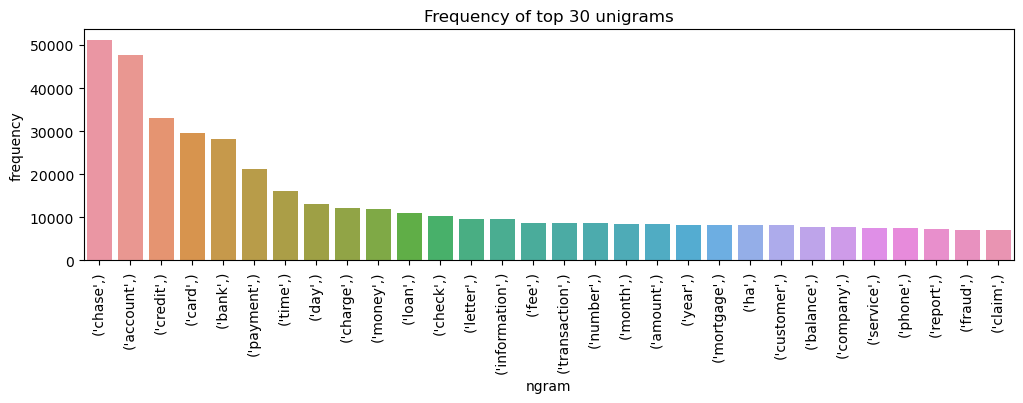

In [67]:
# Lets us graph the above data also
drawgram("unigrams",30)

In [68]:
top10("unigrams")

The top most common words in unigrams along with the number of occurence
[('chase', 51075), ('account', 47594), ('credit', 33099), ('card', 29568), ('bank', 28244), ('payment', 21171), ('time', 16042), ('day', 12988), ('charge', 12236), ('money', 11961)]


In [69]:
getngram("unigrams",10)

Top  10 unigrams and their Frequency
('chase',) ==> 51075
('account',) ==> 47594
('credit',) ==> 33099
('card',) ==> 29568
('bank',) ==> 28244
('payment',) ==> 21171
('time',) ==> 16042
('day',) ==> 12988
('charge',) ==> 12236
('money',) ==> 11961


In [70]:
getngram("bigrams",30)

Top  30 bigrams and their Frequency
('credit', 'card') ==> 12834
('credit', 'report') ==> 3882
('chase', 'credit') ==> 3152
('customer', 'service') ==> 3088
('chase', 'account') ==> 3068
('account', 'chase') ==> 3054
('bank', 'account') ==> 2891
('chase', 'bank') ==> 2847
('account', 'account') ==> 2636
('account', 'bank') ==> 1793
('card', 'account') ==> 1680
('checking', 'account') ==> 1673
('phone', 'call') ==> 1642
('credit', 'score') ==> 1633
('debit', 'card') ==> 1571
('card', 'chase') ==> 1564
('payment', 'payment') ==> 1546
('account', 'credit') ==> 1524
('chase', 'ha') ==> 1494
('money', 'account') ==> 1493
('interest', 'rate') ==> 1298
('credit', 'bureau') ==> 1294
('business', 'day') ==> 1263
('phone', 'number') ==> 1250
('account', 'number') ==> 1214
('letter', 'chase') ==> 1208
('card', 'card') ==> 1200
('card', 'company') ==> 1133
('charge', 'account') ==> 1096
('fund', 'account') ==> 1088


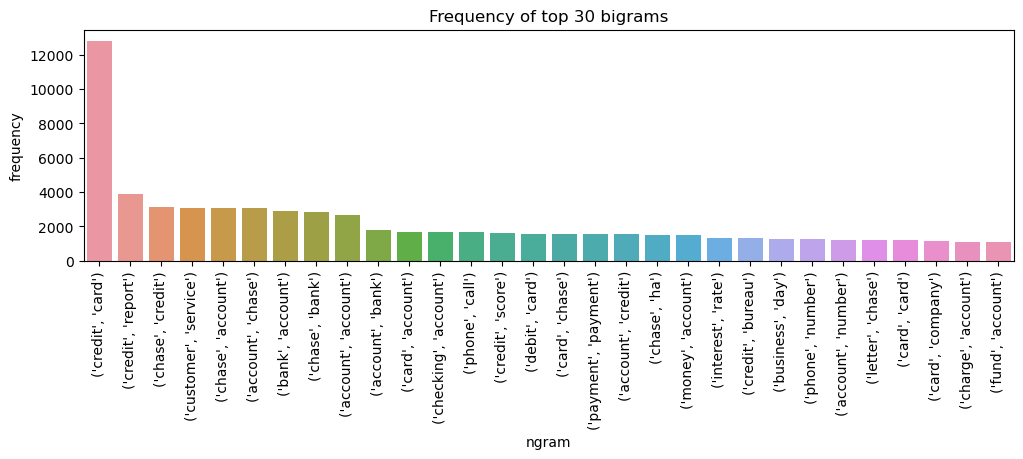

In [71]:
# Lets us graph the above data also
drawgram("bigrams",30)

In [72]:
top10("bigrams")

The top most common words in bigrams along with the number of occurence
[('chase', 99059), ('account', 93472), ('credit', 64946), ('card', 58407), ('bank', 54825), ('payment', 41739), ('time', 31636), ('day', 25742), ('charge', 23928), ('money', 23398)]


In [73]:
getngram("bigrams",10)

Top  10 bigrams and their Frequency
('credit', 'card') ==> 12834
('credit', 'report') ==> 3882
('chase', 'credit') ==> 3152
('customer', 'service') ==> 3088
('chase', 'account') ==> 3068
('account', 'chase') ==> 3054
('bank', 'account') ==> 2891
('chase', 'bank') ==> 2847
('account', 'account') ==> 2636
('account', 'bank') ==> 1793


In [74]:
getngram("trigrams",30)

Top  30 trigrams and their Frequency
('chase', 'credit', 'card') ==> 2137
('credit', 'card', 'account') ==> 1068
('credit', 'card', 'company') ==> 993
('credit', 'card', 'chase') ==> 725
('inquiry', 'credit', 'report') ==> 522
('credit', 'card', 'credit') ==> 519
('account', 'credit', 'card') ==> 433
('card', 'credit', 'card') ==> 404
('bank', 'credit', 'card') ==> 400
('credit', 'reporting', 'agency') ==> 390
('credit', 'card', 'bank') ==> 379
('charge', 'credit', 'card') ==> 370
('credit', 'report', 'credit') ==> 363
('credit', 'reporting', 'act') ==> 329
('account', 'chase', 'account') ==> 328
('account', 'credit', 'report') ==> 326
('chase', 'customer', 'service') ==> 318
('credit', 'card', 'payment') ==> 306
('customer', 'service', 'representative') ==> 299
('credit', 'card', 'card') ==> 293
('credit', 'card', 'balance') ==> 263
('payment', 'credit', 'card') ==> 249
('chase', 'fraud', 'department') ==> 247
('victim', 'identity', 'theft') ==> 247
('consumer', 'protection', 'bureau'

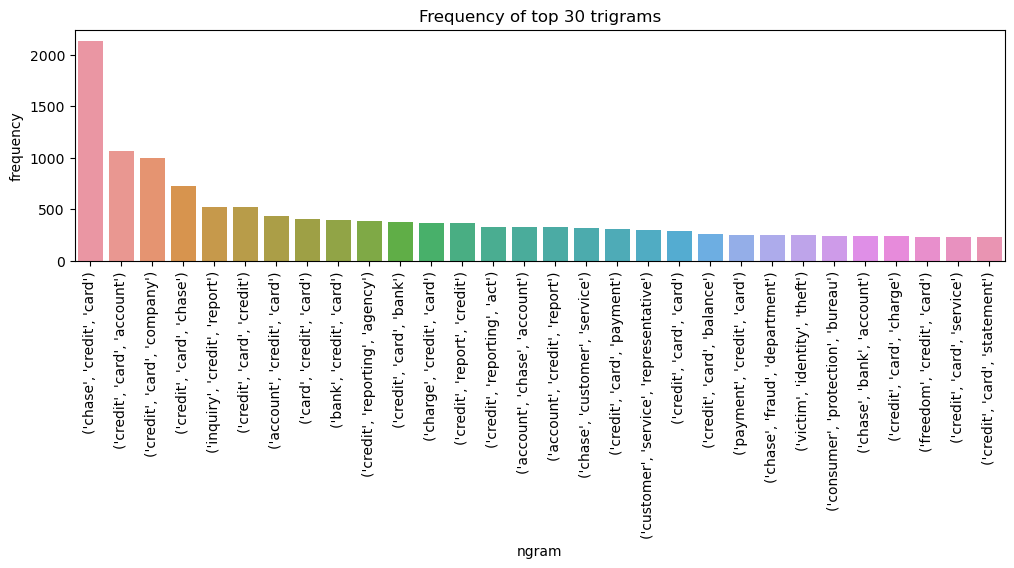

In [75]:
# Lets us graph the above data also
drawgram("trigrams",30)

In [76]:
top10("trigrams")

The top most common words in trigrams along with the number of occurence
[('chase', 144689), ('account', 137352), ('credit', 94442), ('card', 85637), ('bank', 79547), ('payment', 61739), ('time', 46778), ('day', 38266), ('charge', 35221), ('money', 34381)]


In [77]:
getngram("trigrams",10)

Top  10 trigrams and their Frequency
('chase', 'credit', 'card') ==> 2137
('credit', 'card', 'account') ==> 1068
('credit', 'card', 'company') ==> 993
('credit', 'card', 'chase') ==> 725
('inquiry', 'credit', 'report') ==> 522
('credit', 'card', 'credit') ==> 519
('account', 'credit', 'card') ==> 433
('card', 'credit', 'card') ==> 404
('bank', 'credit', 'card') ==> 400
('credit', 'reporting', 'agency') ==> 390


### END OF EDA

In [258]:
# Lets once again check out the df_clean dataframe

In [78]:
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me,i card agent upgrade date agent information order account date consent recording agent,i card agent upgrade date agent information order account date consent recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their 

## Feature Extraction
* Check below for min_df and max_df experimentation

                    ### Please note : min_df value and max_df value experimentation ###

* Initial value of 2 for min_df gave us 6981 features which did not perform well during manual topic modelling as it was 
tough to differentiate between topic by looking at it manually. 
tfidf.get_feature_names_out() was used to inspect the features and there were a lot of irrelevant words ex zombie!!
The feature list was shorten by increasing the value of min_df to include words that appear in at least 0.5% 
of the documents (Features dropped from 6981 to 740)
Experimenting with max_df value did not show much difference in the features obtained and hence was kept at 
initial value of 0.95

In [79]:
# Initializing the tdidf vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=0.005)

### Creating a document term matrix

In [80]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out())

,ability,abuse,access,accordance,account,accounting,acct,ach,act,action,...,wont,word,work,worker,world,worth,writing,year,yesterday,york
0,0.0,0.0,0.0,0.0,0.081085,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.092720,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.124932,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.128250,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21059,0.0,0.0,0.0,0.0,0.057523,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.092440,0.0,0.0
21060,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.12021,0.047895,0.0,0.0
21061,0.0,0.0,0.0,0.0,0.030019,0.0,0.0,0.0,0.0,0.073201,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.048241,0.0,0.0
21062,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.15418,0.0,0.00000,0.062974,0.0,0.0


## Topic Modelling using NMF


In [81]:
from sklearn.decomposition import NMF

In [82]:
# We won't be performing any steps to get optimal number of topics because we already have that number as 5
num_topics = 5
#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40,max_iter=1000)
## ---> max_iter changed to 1000 as it was not converging at default level


In [267]:
## Time to fit!!
nmf_model.fit(dtm)
nmf_fit = nmf_model.fit(dtm)  ## ----> Variable used later
len(tfidf.get_feature_names_out())

740

In [268]:
tfidf.get_feature_names_out()

array(['ability', 'abuse', 'access', 'accordance', 'account',
       'accounting', 'acct', 'ach', 'act', 'action', 'activity',
       'addition', 'address', 'adjustment', 'advance', 'advantage',
       'advertisement', 'advertising', 'advice', 'affidavit', 'afternoon',
       'age', 'agency', 'agent', 'agreement', 'airline', 'alert',
       'amazon', 'andor', 'answer', 'apartment', 'app', 'appeal',
       'application', 'appointment', 'appraisal', 'approval', 'apr',
       'area', 'arrangement', 'ask', 'asset', 'assignment', 'assistance',
       'associate', 'atm', 'attachment', 'attempt', 'attention',
       'attorney', 'authority', 'authorization', 'auto', 'avail', 'bait',
       'balance', 'bank', 'banker', 'banking', 'bankruptcy', 'basis',
       'beginning', 'behalf', 'behavior', 'benefit', 'billing', 'bit',
       'bonus', 'book', 'borrower', 'box', 'branch', 'breach', 'broker',
       'building', 'burden', 'bureau', 'business', 'buyer', 'california',
       'camera', 'cancellati

In [269]:
#Print the Top15 words for each of the topics
feature_names = tfidf.get_feature_names_out()
print("Top 15 words per topic\n")
for i, topic in enumerate(nmf_model.components_):
    print(f'Topic {i}:')
    print([feature_names[idx] for idx in topic.argsort()[-15:]],"\n")

Top 15 words per topic

Topic 0:
['customer', 'fee', 'transaction', 'business', 'checking', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account'] 

Topic 1:
['application', 'year', 'information', 'debt', 'bureau', 'balance', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit'] 

Topic 2:
['sale', 'foreclosure', 'house', 'bank', 'time', 'document', 'letter', 'rate', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan'] 

Topic 3:
['company', 'email', 'phone', 'time', 'service', 'fee', 'purchase', 'claim', 'merchant', 'fraud', 'dispute', 'transaction', 'chase', 'card', 'charge'] 

Topic 4:
['error', 'car', 'mortgage', 'year', 'credit', 'auto', 'chase', 'date', 'time', 'day', 'statement', 'month', 'fee', 'balance', 'payment'] 



In [263]:
##Lets see the same in a tabular format
## Index value represent Topics number ##
H = nmf_model.components_   
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[ i + 1 for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
1,account,bank,check,money,fund,chase,deposit,branch,day,number,checking,business,transaction,fee,customer
2,credit,card,report,inquiry,chase,account,score,company,limit,balance,bureau,debt,information,year,application
3,loan,mortgage,home,chase,modification,property,year,rate,letter,document,time,bank,house,foreclosure,sale
4,charge,card,chase,transaction,dispute,fraud,merchant,claim,purchase,fee,service,time,phone,email,company
5,payment,balance,fee,month,statement,day,time,date,chase,auto,credit,year,mortgage,car,error


In [270]:
# Lets check how many complaints we have by topic number
df_clean['topic'] = nmf_fit.transform(dtm).argmax(axis=1)
complaints_by_topic = df_clean.groupby('topic').size().reset_index(name='count')
print(complaints_by_topic)

   topic  count
0      0   4996
1      1   5130
2      2   3585
3      3   4918
4      4   2435


In [88]:
print(df_clean.shape)

(21064, 5)


In [89]:
#Print the first 5 Complaint for each of the Topics 
#====> Instead we will do 10 from each end, this will also help us try and figure out the topics
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
## We already have the topic that will be finally assigned to the complaints. and they are :
## Bank Account services,Credit card or prepaid card,Mortgage/Loan,Theft/Dispute Reporting,Others
## We will do a manual check to see which pre-defined topics are the complaints are likely to fall in. We will check 
## 20(10-head,10-tail) complaints class from each assigned integars to fine tune our understanding

In [90]:
df_clean_0 = df_clean[df_clean['topic'] == 0]
df_clean_0.head(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
4,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase time they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,son deposit chase account fund chase bank account money son check money bank refuse money son time check owner country time date check number claim number chase,son deposit chase account fund chase bank account money son check money bank refuse money son time check owner country time date check number claim number chase,0
6,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the rig

In [91]:
df_clean_0.tail(10)

complaint_what_happened  \
21018                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ny re chase account closed without cause attn consumer financial protection bureau after giving much thought to my experience i decided to reach out to you chase decided to close my checking accounts without any prior notification i am still unclear as to the reasons why my account where closed and i was not given an opportunity to provide an explanation if one is needed after much deliberation ive concluded that this was chases method of not having to provide me with the bonus under the promotion which i opened my accounts therefore i am writing to you in hopes of having the account reopened with the original promotion being honored since i was not given any reason or explanation for the accounts being closed i can only conclude that it had something to do with the multiple depositing of a check the events that led up to this are as follows on i deposited a check for into my chase account via mobile check deposit the day prior to me leaving for vacation in on the my sister deposited the same check into my account without my knowledge as i was still on vacation in upon my return i visited cha

In [92]:
# After manually checking the complaints, it looks like Topic 0 might belong to  Bank Account services
# This assumption also seemed to be confirmed by the top 15 words for this topic

In [93]:
df_clean_1 = df_clean[df_clean['topic'] == 1]
df_clean_1.head(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me,i card agent upgrade date agent information order account date consent recording agent,i card agent upgrade date agent information order account date consent recording agent,1
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only get applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my 

In [94]:
df_clean_1.tail(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
21039,i have two credit cards with chase ending on and and chase just closed both of my accounts without proper reasons accusing me in misusing rewards which i have not used at all besides that chase listed three other closed accounts which i dont have at all ending on i have no idea why chase closed my two accounts ending on and and sent me a letter explaining that they closed three other accounts ending on because of rewards misuse and you can see from my reward activity that they were not used at all at least for the entire year im legally and i get very when i get harassed with false accusations,i have two credit card with chase ending on and and chase just closed both of my account without proper reason accusing me in misusing reward which i have not used at all besides that chase listed three other closed account which i dont have at all ending on i have no idea why chase closed my two account ending on and and sent me a letter explaining that they closed three other account ending on because of reward misuse and you can see from my reward activity that they were not used at all at least for the entire year im legally and i get very when i get harassed with false accusation,credit card account reason reward chase account idea chase account letter account reward misuse reward activity year im i accusation,credit card account reason reward chase account idea chase account letter account reward misuse reward activity year im i accusation,1
21042,i received an unwanted credit card from chase when i contacted them they immediately began to treat it as fraud i suggested they look internally rather that externally for the origin of the card as it is against the law to send credit cards that have not been requested that suggestion fell on completely deaf ears this the second time chase has mailed an unrequested card to our family,i received an unwanted credit card from chase when i contacted them they immediately began to treat it a fraud i suggested they look internally rather that externally for the origin of the card a it is against the law to send credit card that have not been requested that suggestion fell on completely deaf ear this the second time chase ha mailed an unrequested card to our family,i credit card chase i fraud i origin card law credit card suggestion ear time chase ha card family,i credit card chase i fraud i origin card law credit card suggestion ear time chase ha card family,1
21044,has been noncompliant with removing the unverified account chase card opened date which has been deleted by and and have both completed their research and determined that chase card was not established by myself but keeps verifying this accounts also when i called the company they responded that did not send them all of the verifying evidence to confirm each account is unverified,ha been noncompliant with removing the unverified account chase card opened date which ha been deleted by and and have both completed their research and determined that chase card was not established by myself but keep verifying this account also when i called the company they responded that did not send them all of the verifying evidence to confirm each account is unverified,ha account card date research card verifying account i company evidence account,ha account card date research card verifying account i company evidence account,1
21050,to whom it may concern while checking my most recent credit report i noticed credit inquiries that i did not authorize made by chase credit card company i called the chase credit card company and chase did not comply with my actions i did not authorize anyone employed by these companies to make any inquiry and view my credit report this is a violation of the fair credit reporting act section c and a serious breach of my privacy rights please validate this information with these companies and provide me with copies of any docu

In [95]:
# After manually checking the complaints, it looks like Topic 1 might belong to Credit card or prepaid card
# This assumption also seemed to be confirmed by the top 15 words for this topic

In [96]:
df_clean_2 = df_clean[df_clean['topic'] == 2]
df_clean_2.head(10)

complaint_what_happened  \
23                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [97]:
df_clean_2.tail(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
21021,i was sent an email from on tuesday that stated the forclosure on my home is on hold then why am i receiving notices of a set sale date of quality loan services is attempting to decieve the cfpb agency and me this is an outrage under these circumstances while chase bank sent me a letter on claiming they will have an update on and i also noted chase bank said its my account this is not my account i have no account with chase bank now or ever this is an illegal phantom debt period quality loan services is attempting to illegally sell my home while chase bank claims to be investigating the identity theft equity theft and trust deed fraud as it has been documented and established by the commercial crimes division of the under california penal code pc the filing of false or fraudulent documents are a felony yet did just that filed fraudulent documents with a public office this is inexcusible and criminal they are in noncompliance with fdcpa harrassment and abuse the use or threat of use of violence or other criminal means to harm the physical person reputation or property and the advertisement for sale of any debt to coerce payment of the debt,i was sent an email from on tuesday that stated the forclosure on my home is on hold then why am i receiving notice of a set sale date of quality loan service is attempting to decieve the cfpb agency and me this is an outrage under these circumstance while chase bank sent me a letter on claiming they will have an update on and i also noted chase bank said it my account this is not my account i have no account with chase bank now or ever this is an illegal phantom debt period quality loan service is attempting to illegally sell my home while chase bank claim to be investigating the identity theft equity theft and trust deed fraud a it ha been documented and established by the commercial crime division of the under california penal code pc the filing of false or fraudulent document are a felony yet did just that filed fraudulent document with a public office this is inexcusible and criminal they are in noncompliance with fdcpa harrassment and abuse the use or threat of use of violence or other criminal mean to harm the physical person reputation or property and the advertisement for sale of any debt to coerce payment of the debt,i email tuesday forclosure home hold i notice set sale date quality loan service cfpb agency outrage circumstance bank letter update i bank account account account bank debt period quality loan service home bank claim identity theft equity theft trust deed fraud crime division california code pc filing document felony document office noncompliance harrassment use threat use violence mean person reputation property advertisement sale debt payment debt,i email tuesday forclosure home hold i notice set sale date quality loan service cfpb agency outrage circumstance bank letter update i bank account account account bank debt period quality loan service home bank claim identity theft equity theft trust deed fraud crime division california code pc filing document felony document office noncompliance harrassment use threat use violence mean person reputation property advertisement sale debt payment debt,2
21037,we are victims of excessive mortgage fraud it appears attorney s judges bank officials hoa members and many other agencies are involved fraud on both personal and commerical property the fraud as led us into bankruptcy the trustee is not doing his job but appears to violate every law in order to liquidate assets illegally the fraud was uncovered my spouse during everyone is trying to cover their tracks it is pathetic false bankruptcy claims are being filed so you can imagine who are involved we contact companies to validate a debt you can never get the correct information because it is fraudulent or they will never file a claim but payments have been made and stolen and the 

In [98]:
# After manually checking the complaints, it looks like Topic 2 might belong to Mortgage/Loan
# This assumption also seemed to be confirmed by the top 15 words for this topic


In [99]:
df_clean_3 = df_clean[df_clean['topic'] == 3]
df_clean_3.head(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
8,on i made a payment to an online retailer using chase quick pay with on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank i contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at that can give me more information about the recipient that my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team i called the number listed in the email and explained my situation to then be transferred to the claims department i was directed to call and ask them about the transaction because chase did not have any information outside of what i provided when initiating the transfer i felt like this agent was trying to get me to end the call as quickly as possible and i had to interrupt her closing script to ask for a contact number at and didnt have an opportunity to get any information about what the right questions would be to ask or what words and phrases i should use to get the information i was looking for i called whos automated system initially directed me to call my bank because i used the banks app to initiate the transaction i called again to navigate their menus and talk to a customer service agent they told me that all of the information about the transaction would in chase s system because i used the banks app to perform the transaction she stayed on the line with me until i understood everything that i should ask and had a better understanding of the situation i ended the call and called chase again when i called chase the second time the agent tried to look up the information about the receiving bank but could not find any additional information she then asked me why i needed this information and i explained my situation again i was once again transferred to the claims department who told me that i needed to contact to get the information i was looking for after i told her that i had already contacted them she finally admitted that there was nothing that she could do due to the nature of the transaction and that these types of transactions are not secured she said that chase had no information about the recipient other than the email address that i inputted and that the recipients banking information was not kept in the system in both phone calls they asked if i initiated that transaction and used that to absolve themselves of all responsibility in regards to this matter during this whole process it felt like chase was not transparent about their policies regarding these types of transactions nor were they helpful in helping me get any information about the situation these transactions are advertised as a fast safe and easy way to send money but seem to be a dangerous way to do business i feel deceived by chase s advertising and further victimized by the way i was treated by the members on their customer service team,on i made a payment to an online retailer using chase quick pay with on the chase website i realized that this was a scam website after no confirmation product or response to any inquiry regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailer bank i contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at that can give me more information ab

In [100]:
df_clean_3.tail(10)

complaint_what_happened  \
21030                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        on my wife and i checked into an for what was supposed to be a day stay upon checking in that evening after flying into our destination we were extremely disappointed in the cleanliness and filth of the home so we left thing in the morning and checked into a local hotel refused to give us a refund for our stay for the nights we did not stay and insisted that they keep the full even after we sent them photos of how disgusting the house was at this point i called chase bank to dispute the charge and chase gave my a provisional credit chase was able to see that we in fact checked into a hotel seeing that i used my chase credit card for the hotel they said that was sufficient to show that we did not stay at the and we thought the issue was resolved i explained to chase that i was willing to pay for the one night hours we did stay and they said there was no way to refund only of the nights well now over months later chase is reversing of the that was originally reversed after phone calls with chase i have been told i have no recourse because provided documentation that substantiates the charge really so what was supposed to be a night is now chase could not refund my account only the applicable for the nights we did not stay but they can now credit for one night chase refuses to send me a copy of s response to them so that i can properly refute their response i have received no communication from visa and chase said visa has no p

In [101]:
# After manually checking the complaints, it looks like Topic 3 might belong to Theft/Dispute Reporting
# This assumption also seemed to be confirmed by the top 15 words for this topic



In [102]:
df_clean_4 = df_clean[df_clean['topic'] == 4]
df_clean_4.head(10)

complaint_what_happened  \
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [103]:
df_clean_4.tail(10)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
20991,j p morgan chase foreclosed on my mortgage and made when it was sold and they did not give me penny the address is ct they ran there own bank i sent them months payment and they returned it in a refund and foreclosed the payment was sent days late so i sent them the back payment the second payment on the and the next months payment a month ahead,j p morgan chase foreclosed on my mortgage and made when it was sold and they did not give me penny the address is ct they ran there own bank i sent them month payment and they returned it in a refund and foreclosed the payment was sent day late so i sent them the back payment the second payment on the and the next month payment a month ahead,j p chase mortgage address bank i month payment refund payment day payment payment month payment month,j p chase mortgage address bank i month payment refund payment day payment payment month payment month,4
20997,my credit card due date is on i made an online payment on paying off the balance on the account on chase charged an interest fee on a balance account when i asked to have the fees removed they refused,my credit card due date is on i made an online payment on paying off the balance on the account on chase charged an interest fee on a balance account when i asked to have the fee removed they refused,credit card date i payment balance account chase interest fee balance account i fee,credit card date i payment balance account chase interest fee balance account i fee,4
21003,my car was stolen on the police recovered it on and my primary insurance company deemed it a total loss i also have gap insurance thru a subsidiary of the loan is thru chase bank i contacted chase bank customer service who transferred me around times having to repeat the same story to different people they finally transferred me to a department that was now in charge of my account during this time period i did not receive any information from chase bank they did not contact me by phone to inform me in writing regarding any information on my account on i made a payment of which is my car payment chase had assessed me a late charge but waived the late charge on chase then received and credited a payment from my insurance company in the amount of on further chase received and credited to my account a payment from my gap insurance company of on chase refuses to acknowledge those payments on my behalf from my insurance companies and that they credited to my account as payments on my account and has destroyed my credit score by reporting me as latedelinquent they have done this because as one of their customer service representatives explained to me payments from my insurance company on my behalf dont count as payments really they have received payments and credited payments on my loan from my insurance companies on my behalf yet they can just erroneously ruin my credit because they have some internal policy that will accept the money but wont accept payments on my loan on my behalf i am not seeking any type of financial compensation although i do believe they should also waive the late charge they have assessed me of on after receiving payment from my insurance company i am seeking relief from chase bank s internal policies that penalize customers for no good reason and to remove the derogatory credit information that they placed onto my credit reports which is now on my report for years the credit bureau s wont do anything they take the side of the creditors frankly it is amazing i am the victim of a crime with my car being stolen and now i am the victim of corporate arrogance from chase bank who is destroying my credit for years thank you,my car was stolen on the police recovered it on and my primary insurance company deemed it a total loss i also have gap insurance thru a subsidiary of the loan is thru chase bank i contacted chase bank customer service who transferred me around 

In [104]:
# Topic 4 seems to be mixed bag and it could actually be assigned to multiple other topics, fortunately we have
# Others and it will fit right into that category

In [105]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card",2:"Mortgage/Loan",3:"Theft/Dispute Reporting",4:"Others"   }
#Replace Topics with Topic Names

df_clean['topic'] = df_clean['topic'].map(Topic_names)

In [106]:
# Checking to see if the names have been assigned to topic numbers
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,Bank Account services
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me,i card agent upgrade date agent information order account date consent recording agent,i card agent upgrade date agent information order account date consent recording agent,Credit card or prepaid card
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though th

### Building supervised model

In [107]:
#Create the dictionary of Topic names and Topics

Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Mortgage/Loan":2,"Theft/Dispute Reporting":3,"Others":4   }

#Replace Topics names with numbers for modelling
df_clean['topic'] = df_clean['topic'].map(Topic_names)
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,topic
0,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
1,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who was misled me,i card agent upgrade date agent information order account date consent recording agent,i card agent upgrade date agent information order account date consent recording agent,1
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
3,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and o

In [108]:
# Lets check the shape again
df_clean.shape

(21064, 5)

In [109]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened','topic']]

In [110]:
training_data.shape

(21064, 2)

### Creating data from the training_data dataframe in the format that we will need for modelling


In [231]:
#Code to get the Vector count
count=CountVectorizer()
vectorcount = count.fit_transform(training_data['complaint_what_happened'])

#Code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(vectorcount)
tfidf_matrix = tfidf_transformer.transform(vectorcount)
tfidf_matrix.shape

(21064, 32739)

In [112]:
# splitting data into train/test split for modeling 
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, training_data['topic'], test_size=0.25, random_state=40)

In [113]:
#Checking the training data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15798, 32739)
(15798,)
(5266, 32739)
(5266,)


### Function to evaluate models that we will build

In [114]:
# List of topic from the Topic_names we made above
namelist=list(Topic_names.keys())


### Function to evaluate the model performance

def modelperformance(X_train,y_train,X_test,y_test,model):
    y_pred_train=model.predict(X_train) #====> To check f1 score on train data too
    y_pred=model.predict(X_test)
    print("*************** F1 score on train data***************")
    print(f1_score(y_train, y_pred_train, average="weighted"),"\n")
    print("*************** Performance Metrics for Model on Test Data***************")
    #f1 Score
    print("The F1 score for this model is ")
    print(f1_score(y_test, y_pred, average="weighted"))
    # Classification metrics
    print(classification_report(y_test, y_pred, target_names=namelist))
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=namelist,yticklabels=namelist,annot=True,fmt="d")

    




### Logistic Regression

In [115]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
lr = LogisticRegression(max_iter=1000,solver='lbfgs') 
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

*************** F1 score on train data***************
0.9759328636099419 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.9271503466982767
                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.93      1236
Credit card or prepaid card       0.93      0.95      0.94      1274
              Mortgage/Loan       0.95      0.93      0.94       919
    Theft/Dispute Reporting       0.91      0.91      0.91      1265
                     Others       0.95      0.87      0.91       572

                   accuracy                           0.93      5266
                  macro avg       0.93      0.92      0.93      5266
               weighted avg       0.93      0.93      0.93      5266



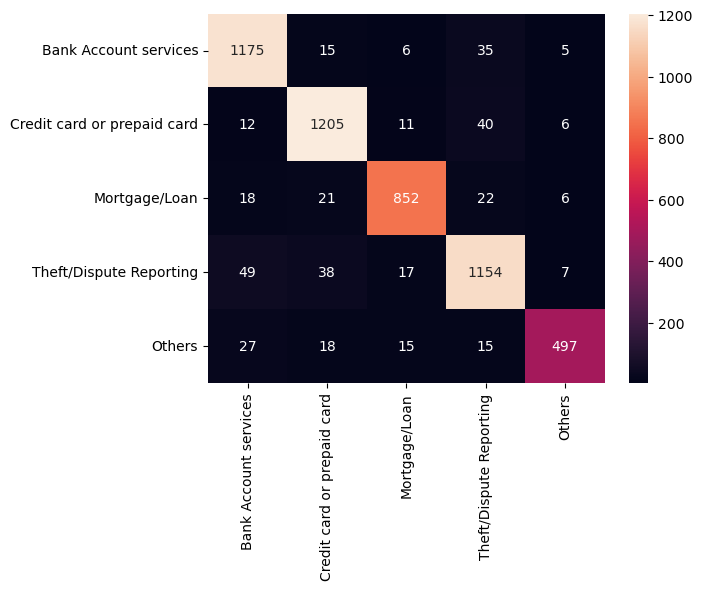

In [116]:
# Checking Model performance
modelperformance(X_train,y_train,X_test,y_test,lr)

### Hyperparameter tuning

#### Gridsearch 

In [117]:
# We are using lbfgs as solver and because it only supports l2 regularization , we will grid search for only l2
param_grid = {'penalty': ['l2'],'C': np.logspace(-4, 4, 20)}
grid_search_lr = GridSearchCV(lr, param_grid=param_grid, cv=3,scoring='f1_weighted',verbose=1)
grid_search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l2']},
             scoring='f1_weighted', verbose=1)

In [118]:
grid_search_lr.best_estimator_

LogisticRegression(C=4.281332398719396, max_iter=1000)

*************** F1 score on train data***************
0.996012893133838 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.9289492293715146
                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1236
Credit card or prepaid card       0.93      0.94      0.94      1274
              Mortgage/Loan       0.95      0.93      0.94       919
    Theft/Dispute Reporting       0.91      0.91      0.91      1265
                     Others       0.94      0.89      0.92       572

                   accuracy                           0.93      5266
                  macro avg       0.93      0.93      0.93      5266
               weighted avg       0.93      0.93      0.93      5266



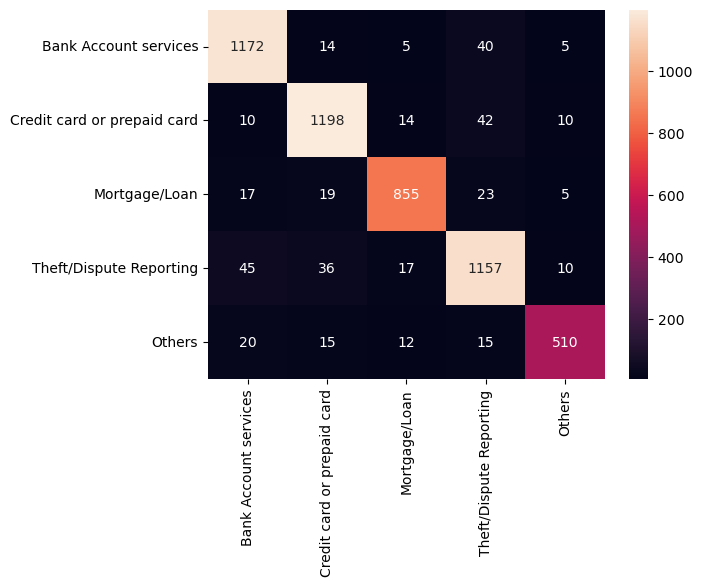

In [119]:
# Checking Model performance
modelperformance(X_train,y_train,X_test,y_test,grid_search_lr.best_estimator_)

### Decision Tree

In [120]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [121]:
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

*************** F1 score on train data***************
1.0 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.7760691455910068
                             precision    recall  f1-score   support

      Bank Account services       0.80      0.78      0.79      1236
Credit card or prepaid card       0.79      0.82      0.81      1274
              Mortgage/Loan       0.83      0.80      0.81       919
    Theft/Dispute Reporting       0.72      0.73      0.72      1265
                     Others       0.74      0.76      0.75       572

                   accuracy                           0.78      5266
                  macro avg       0.78      0.77      0.78      5266
               weighted avg       0.78      0.78      0.78      5266



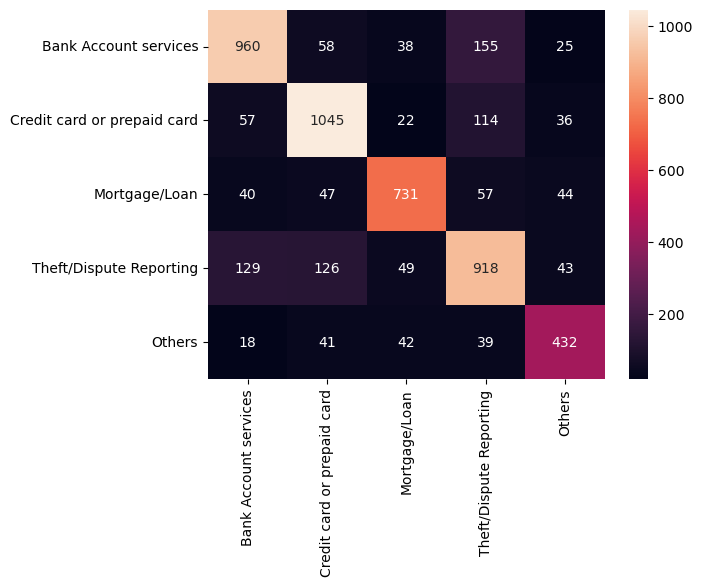

In [122]:
# Checking Model performance
modelperformance(X_train,y_train,X_test,y_test,dt)

In [123]:
# Model Overfitting, Lets try and do some hyperparameter tuning

### Hyperparameter tuning

#### Gridsearch

In [124]:
param_grid = {'max_depth': [2,3,5,10,20,30,40,50],
              'min_samples_split': [2, 5, 10,20],
              'min_samples_leaf': [5,10,20,50,100,500]}
grid_search_dt = GridSearchCV(dt, param_grid=param_grid, cv=3,scoring='f1_weighted',verbose=1)
grid_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted', verbose=1)

*************** F1 score on train data***************
0.8732051078789617 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.7954413942992524
                             precision    recall  f1-score   support

      Bank Account services       0.82      0.81      0.82      1236
Credit card or prepaid card       0.80      0.84      0.82      1274
              Mortgage/Loan       0.87      0.79      0.83       919
    Theft/Dispute Reporting       0.72      0.76      0.74      1265
                     Others       0.77      0.75      0.76       572

                   accuracy                           0.79      5266
                  macro avg       0.80      0.79      0.79      5266
               weighted avg       0.80      0.79      0.80      5266



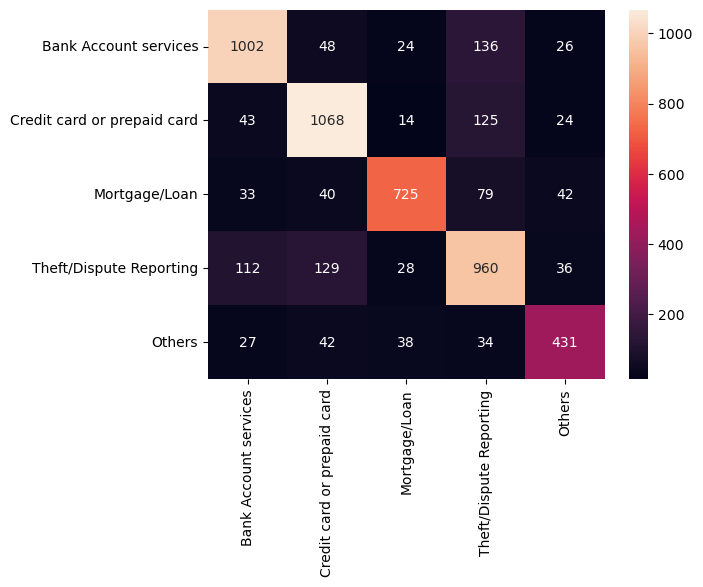

In [125]:
# Checking Model performance
modelperformance(X_train,y_train,X_test,y_test,grid_search_dt.best_estimator_)

In [126]:
# Decision tree both tuned and untuned performed worse than logistic regression on F1 score

### Random Forest

In [127]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [128]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

*************** F1 score on train data***************
1.0 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.8247485787063079
                             precision    recall  f1-score   support

      Bank Account services       0.81      0.91      0.86      1236
Credit card or prepaid card       0.79      0.90      0.85      1274
              Mortgage/Loan       0.87      0.86      0.87       919
    Theft/Dispute Reporting       0.85      0.82      0.83      1265
                     Others       0.93      0.47      0.63       572

                   accuracy                           0.83      5266
                  macro avg       0.85      0.79      0.81      5266
               weighted avg       0.84      0.83      0.82      5266



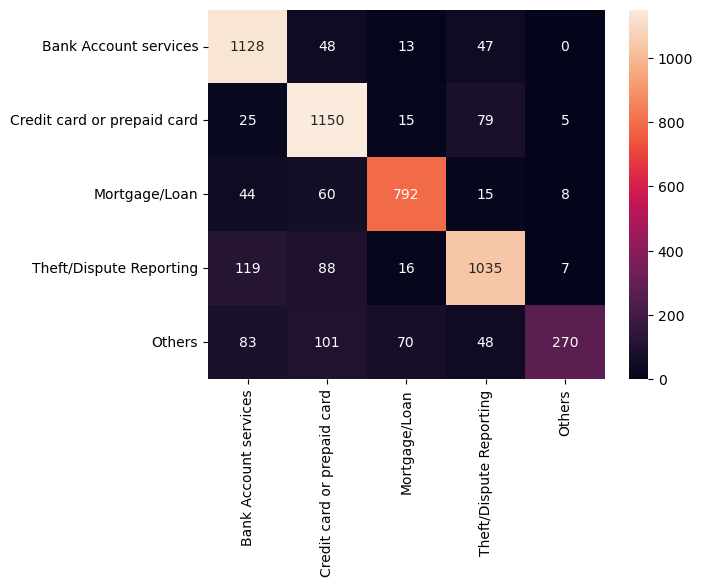

In [129]:
# Checking Model performance
modelperformance(X_train,y_train,X_test,y_test,rf)

In [130]:
# Again, it looks like the model overfit

### Hyperparameter tuning

#### Gridsearch

In [131]:
param_grid = {'max_depth': [2,3,5,10,20,30,40,50],
              'min_samples_split': [2, 5, 10,20],
              'min_samples_leaf': [5,10,20,50,100,500],
              'n_estimators': [10, 25, 50, 100]
             }
grid_search_rf = GridSearchCV(rf, param_grid=param_grid, cv=3,scoring='f1_weighted',verbose=1)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1_weighted', verbose=1)

*************** F1 score on train data***************
0.8861012247246389 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.7832762320500682
                             precision    recall  f1-score   support

      Bank Account services       0.78      0.88      0.83      1236
Credit card or prepaid card       0.72      0.89      0.80      1274
              Mortgage/Loan       0.86      0.82      0.84       919
    Theft/Dispute Reporting       0.83      0.81      0.82      1265
                     Others       0.96      0.32      0.48       572

                   accuracy                           0.79      5266
                  macro avg       0.83      0.74      0.75      5266
               weighted avg       0.81      0.79      0.78      5266



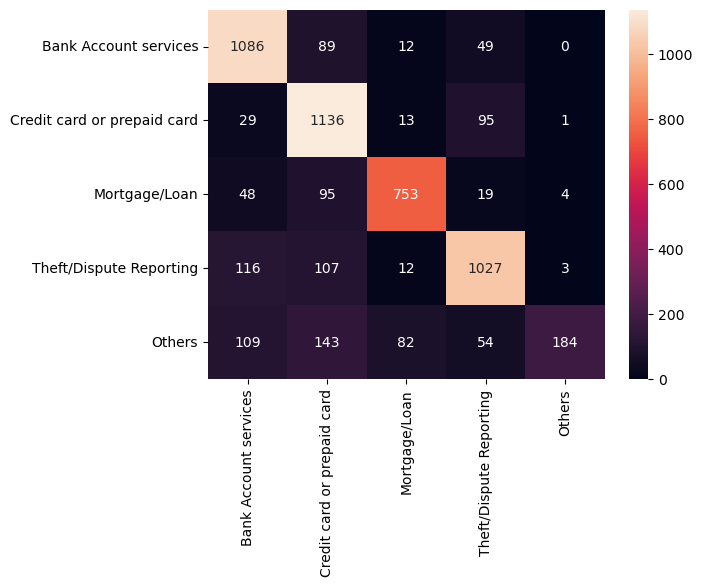

In [132]:
# Checking model performance
modelperformance(X_train,y_train,X_test,y_test,grid_search_rf.best_estimator_)

In [133]:
# Both tuned and untuned rf performed worse than LR

### Naive Bayes

In [134]:
from sklearn.naive_bayes import MultinomialNB

In [135]:
nb=MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

*************** F1 score on train data***************
0.7147116868953728 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.7025573820712985
                             precision    recall  f1-score   support

      Bank Account services       0.70      0.89      0.79      1236
Credit card or prepaid card       0.68      0.83      0.75      1274
              Mortgage/Loan       0.88      0.71      0.79       919
    Theft/Dispute Reporting       0.76      0.82      0.79      1265
                     Others       1.00      0.05      0.09       572

                   accuracy                           0.74      5266
                  macro avg       0.80      0.66      0.64      5266
               weighted avg       0.77      0.74      0.70      5266



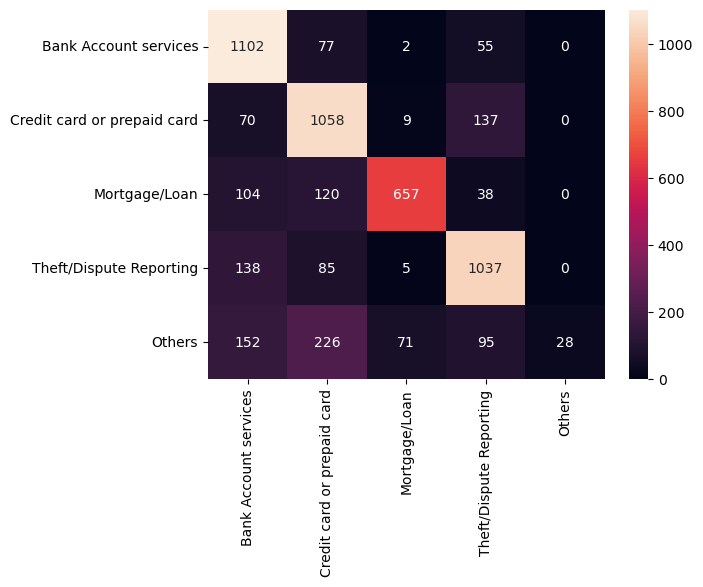

In [136]:
modelperformance(X_train,y_train,X_test,y_test,nb)

#### We have trained a total of 7 models as follows
1) Logistic Regression - Untuned

2) Logistic Regression - Tuned

3) Decision Tree - Untuned

4) Decision Tree - Tuned

5) Random Forest - Untuned

6) Random Forest - Tuned

and lastly

7) Naive Bayes - Untuned


Among all the models, the best estimator from grid search cv for LR performed the best on both Train and test data
We will choose that as my final classifier 

*************** F1 score on train data***************
0.996012893133838 

*************** Performance Metrics for Model on Test Data***************
The F1 score for this model is 
0.9289492293715146
                             precision    recall  f1-score   support

      Bank Account services       0.93      0.95      0.94      1236
Credit card or prepaid card       0.93      0.94      0.94      1274
              Mortgage/Loan       0.95      0.93      0.94       919
    Theft/Dispute Reporting       0.91      0.91      0.91      1265
                     Others       0.94      0.89      0.92       572

                   accuracy                           0.93      5266
                  macro avg       0.93      0.93      0.93      5266
               weighted avg       0.93      0.93      0.93      5266



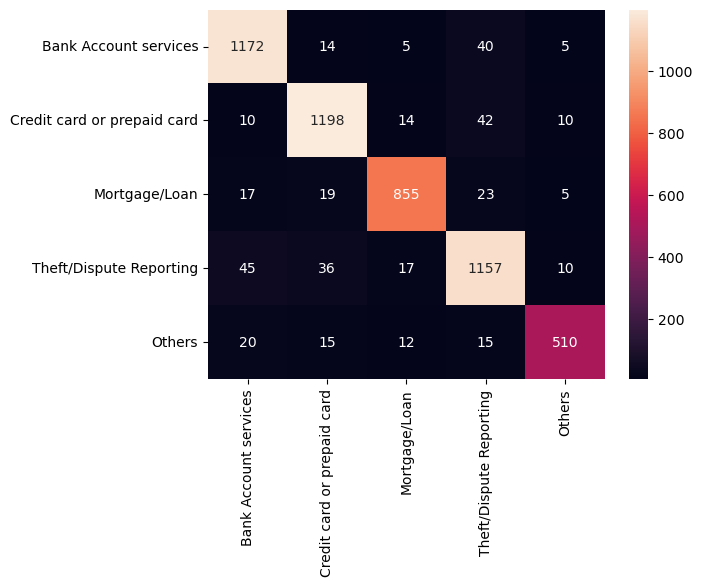

In [271]:
#Lets recall the metrics again for that model
modelperformance(X_train,y_train,X_test,y_test,grid_search_lr.best_estimator_)

### Testing on Custom complaint 


In [174]:
## Testing Model on custom complaint using artificially generated complains

In [282]:
# Function to classify text
def classify_new_text(new_text):
    # Clean up
    new_text =getnewtext(new_text)  #===> Clean the text
    
    # preprocess new text with CountVectorizer and TfidfTransformer
    
    new_text_counts =  CountVectorizer(vocabulary=count.vocabulary_).fit_transform([new_text])
    new_text_tfidf = tfidf_transformer.transform(new_text_counts)

    # make prediction 
    predicted_class = grid_search_lr.best_estimator_.predict(new_text_tfidf)[0]
    final_pred=namelist[predicted_class] #===> namelist is the list of classes that we assigned on top
    print("This Complain can be classfied as :")
    print(final_pred)




In [283]:
# Custom complaint 1
#Generated using chatgpt using the prompt -  Sample text complaint about misuse of credit card
Fraud_complaint="Yesterday, I received my credit card statement and was shocked to see several unauthorized charges made on my account. I immediately contacted the bank's customer service and they assured me that they would investigate the matter. However, I am concerned about the safety of my account and would like to know what measures are being taken to prevent such incidents in the future. I also want to know when I can expect a resolution to this issue and when the charges will be removed from my account. This situation has caused me a great deal of stress and I hope that the bank can resolve it as soon as possible."

In [284]:
# Predicting to see if our complaint has been classified properly

predicted_class = classify_new_text(Fraud_complaint)


This Complain can be classfied as :
Theft/Dispute Reporting


In [285]:
# Labels Predicted as expected

In [286]:
# Custom complaint 2
#Generated using chatgpt using the prompt -  Sample text complaint about bank account or banking service
bank_service="I am writing to inquire about my recent transaction history with your bank. I noticed that there were some discrepancies in the charges that were applied to my account, and I would like to request clarification on these charges.Additionally, I have been experiencing some issues with accessing my online banking account. Despite several attempts, I have been unable to log in and view my account details. I would appreciate it if you could assist me in resolving this issue as soon as possible."

In [287]:
# Predicting to see if our complaint has been classified properly

predicted_class = classify_new_text(bank_service)


This Complain can be classfied as :
Bank Account services


In [288]:
# Labels Predicted as expected

In [291]:
# Custom complaint 3
#Generated using chatgpt using the prompt -  Sample text complaint about loan/mortage
loan="I am writing to inquire about the status of my mortgage application. I submitted my application three weeks ago and I have yet to receive any updates. I would appreciate it if you could provide me with an estimated timeline for when my application will be reviewed and processed."

In [292]:
predicted_class = classify_new_text(loan)


This Complain can be classfied as :
Mortgage/Loan


In [ ]:
# Labels Predicted as expected